In [1]:
import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt
import scipy.stats as stats

def gen_gaussian_data(N, dim=2, dist=1, stddev=1.0):
    # generate N random data vectors from two Gaussian clusters
    data = []
    # first cluster is always centered on [0, 0, 0, ...]
    cluster1mean = np.zeros(dim)
    cluster1size = N // 2
    for i in range(cluster1size):
        data.append(np.random.normal(cluster1mean, stddev, (dim)))

    # second cluster is placed along the vector dist*[1, 1, 1, ...]
    cluster2mean = np.zeros(dim) + dist
    for i in range(N-cluster1size):
        data.append(np.random.normal(cluster2mean, stddev, (dim)))
    return np.array(data), cluster1mean, cluster2mean


def plot_data(data):
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(data[:,0], data[:,1])
    ax.axvline(0, ls='--', c='grey')
    ax.axhline(0, ls='--', c='grey')
    plt.show()
    plt.close()

def plot_cluster(data, cluster0, cluster1):
    cluster0 = np.array(cluster0)
    cluster1 = np.array(cluster1)
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(cluster0[:,0], cluster0[:,1], c='r')
    ax.scatter(cluster1[:,0], cluster1[:,1], c='b')
    plt.show()
    plt.close()

In [22]:
from active_coresets.coreset_algorithms import bayesian_inference
from active_coresets.classical_algorithms import RandomSampler, GIGACoreset
from active_coresets.quantum_algorithms import ClassicalExponentialSampler, VQT, QAOA
from active_coresets.data_structures import Coreset, Model

from typing import List, Tuple

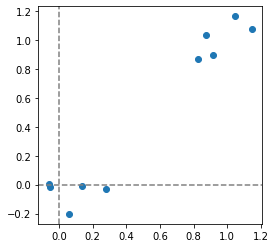

In [4]:
num_data = 10
data, c1, c2 = gen_gaussian_data(num_data, stddev=0.1)
shuffle(data)
plot_data(data)

In [5]:
class ClusteringModel(Model):
    def __init__(self, clusters: Tuple[List[np.ndarray], List[np.ndarray]]):
        self.clusters = clusters
        self.cluster0_center = np.average(clusters[0], axis=0) if len(clusters[0]) > 0 else [0.0, 0.0]
        self.cluster1_center = np.average(clusters[1], axis=0) if len(clusters[1]) > 0 else [0.0, 0.0]
    
    def evaluate_on_coreset(self, coreset: Coreset) -> float:
        total_dist = 0.0
        for data, weight in coreset.coreset:
            if any((data == x).all() for x in self.clusters[0]):
                total_dist += weight * np.linalg.norm(data - self.cluster0_center)
            else:
                total_dist += weight * np.linalg.norm(data - self.cluster1_center)
        return -total_dist
    
    def evaluate_on_point(self, data: np.ndarray) -> float:
        if any((data == x).all() for x in self.clusters[0]):
            return np.linalg.norm(data - self.cluster0_center)
        else:
            return np.linalg.norm(data - self.cluster1_center)
        

In [41]:
def cluster_loglikelihood(data: np.ndarray, models: List[ClusteringModel]) -> np.ndarray:
    #TODO: maybe optimize this better
    ll_vecs = np.zeros((data.shape[0], len(models)))
    for i in range(data.shape[0]):
        for j in range(len(models)):
            ll_vecs[i][j] = models[j].evaluate_on_point(data[i])
    return ll_vecs


In [69]:
def cluster_from_bitstring(bitstring: str) -> Model:
    cluster0 = []
    cluster1 = []
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            cluster0.append(data[num_data - 1 - i])
        else:
            cluster1.append(data[num_data - 1 - i])
    return ClusteringModel((cluster0, cluster1))

In [7]:
Y = []
for model_bitstring in range(2**(num_data)):
    cluster0 = []
    cluster1 = []
    for i in range(num_data):
        if (model_bitstring >> i) & 0x1 == 0:
            cluster0.append(data[i])
        else:
            cluster1.append(data[i])
    Y.append(ClusteringModel((cluster0, cluster1)))

{(1, 1): -0.3366721855635702}
[(-0.3366721855635702, ['Z', 'Z'])]
Cost at step 0: -0.7139004095037876
Cost at step 20: -0.769066419860976
Cost at step 40: -1.0990302867858261
Cost at step 60: -1.2580070503901128
Cost at step 80: -1.320955380069423
Cost at step 100: -1.3737046327736138
Cost at step 120: -1.3719616959894598
Cost at step 140: -1.3788871932833349
Cost at step 160: -1.384358774343312
Cost at step 180: -1.3853545857252763
Cost at step 200: -1.3862032120793675
Cost at step 220: -1.3862878019943854
Cost at step 240: -1.3862931696521743
Cost at step 260: -1.3862940710289906
Cost at step 280: -1.3862943158406746
Cost at step 300: -1.386294338861481
Cost at step 320: -1.3862943560641638
Cost at step 340: -1.3862943602041824
Cost at step 360: -1.3862943599915516
Cost at step 380: -1.3862943608934915
 final_simplex: (array([[5.08645631, 4.39423781, 0.79899351, 4.73173185, 2.79506144,
        0.27555624, 3.24397053, 0.69314825, 0.69315217],
       [5.08646961, 4.39430011, 0.79899823

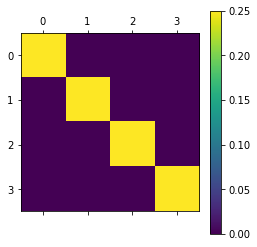

Final Entropy: 1.3862943611068728
Final Expectation Value: -4.7062203160919136e-07
Final Cost: -1.3862943611068728
10
1100101100
{(0, 1, 1): 4.342177144365026, (1, 0, 1): -0.2984618105755552, (1, 1, 0): -0.3366721855635702}
[(-0.3366721855635702, ['Z', 'Z', 'I']), (-0.2984618105755552, ['Z', 'I', 'Z']), (4.342177144365026, ['I', 'Z', 'Z'])]
Cost at step 0: -0.6752018179546154
Cost at step 20: -0.6931570015460853
Cost at step 40: -0.7819841644487979
Cost at step 60: -1.2820817634941173
Cost at step 80: -1.2640854752802742
Cost at step 100: -1.3510574590699518
Cost at step 120: -1.343662412312586
Cost at step 140: -1.3712191808268055
Cost at step 160: -1.4274909873493968
Cost at step 180: -1.6312133214389184
Cost at step 200: -1.640013244785616
Cost at step 220: -1.9463154088528651
Cost at step 240: -1.994000107534774
Cost at step 260: -2.0399680998329406
Cost at step 280: -2.058589717957031
Cost at step 300: -2.057127833749624
Cost at step 320: -2.0608396335701507
Cost at step 340: -2.0

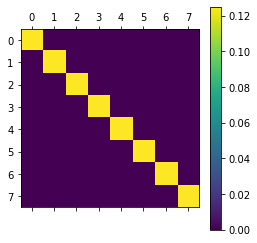

Final Entropy: 2.079441541675818
Final Expectation Value: -6.677084380957155e-07
Final Cost: -2.079441541675818
110
1100101100
{(0, 0, 1, 1): 3.889078604799108, (0, 1, 1, 0): 4.342177144365026, (0, 1, 0, 1): 3.7831881402545156, (1, 0, 1, 0): -0.2984618105755552, (1, 0, 0, 1): -0.3041295564224072, (1, 1, 0, 0): -0.3366721855635702}
[(-0.3366721855635702, ['Z', 'Z', 'I', 'I']), (-0.2984618105755552, ['Z', 'I', 'Z', 'I']), (-0.3041295564224072, ['Z', 'I', 'I', 'Z']), (4.342177144365026, ['I', 'Z', 'Z', 'I']), (3.7831881402545156, ['I', 'Z', 'I', 'Z']), (3.889078604799108, ['I', 'I', 'Z', 'Z'])]
Cost at step 0: -1.4115753249410337
Cost at step 20: -1.4224420865819272
Cost at step 40: -1.4447086542923517
Cost at step 60: -1.4863202212130133
Cost at step 80: -1.5222433518287906
Cost at step 100: -1.552154941676325
Cost at step 120: -1.5785873852952381
Cost at step 140: -1.720200097759644
Cost at step 160: -2.130902074913723
Cost at step 180: -2.2621229487454935
Cost at step 200: -2.292897883

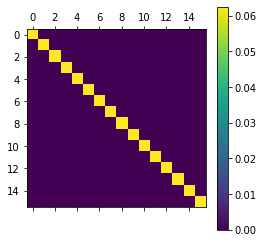

Final Entropy: 2.7725887058491567
Final Expectation Value: 0.00021783878205783314
Final Cost: -2.7725887058491567
0011
0011010011
{(0, 0, 1, 1, 0): 3.889078604799108, (0, 1, 1, 0, 0): 4.342177144365026, (1, 0, 0, 0, 1): 0.021500084000107132, (0, 1, 0, 1, 0): 3.7831881402545156, (1, 0, 1, 0, 0): -0.2984618105755552, (0, 0, 1, 0, 1): -0.1785529009998023, (1, 0, 0, 1, 0): -0.3041295564224072, (0, 0, 0, 1, 1): -0.15934861518288904, (1, 1, 0, 0, 0): -0.3366721855635702, (0, 1, 0, 0, 1): -0.17761273011560744}
[(-0.3366721855635702, ['Z', 'Z', 'I', 'I', 'I']), (-0.2984618105755552, ['Z', 'I', 'Z', 'I', 'I']), (-0.3041295564224072, ['Z', 'I', 'I', 'Z', 'I']), (0.021500084000107132, ['Z', 'I', 'I', 'I', 'Z']), (4.342177144365026, ['I', 'Z', 'Z', 'I', 'I']), (3.7831881402545156, ['I', 'Z', 'I', 'Z', 'I']), (-0.17761273011560744, ['I', 'Z', 'I', 'I', 'Z']), (3.889078604799108, ['I', 'I', 'Z', 'Z', 'I']), (-0.1785529009998023, ['I', 'I', 'Z', 'I', 'Z']), (-0.15934861518288904, ['I', 'I', 'I', 'Z',

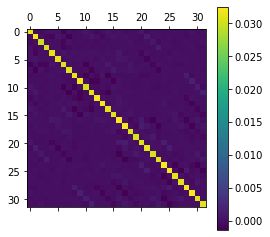

Final Entropy: 3.4585138461091436
Final Expectation Value: -0.02885415845223485
Final Cost: -3.4585138461091436
10000
0011010011


In [12]:
A = RandomSampler()
B = VQT(0)

final_model = bayesian_inference(list(data), cluster_from_bitstring, num_data, 6, A, B)

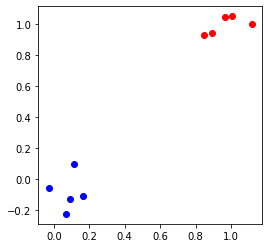

In [13]:
plot_cluster(data, final_model.clusters[0], final_model.clusters[1])

In [62]:
A = RandomSampler()
B = QAOA(1)

final_model = bayesian_inference(list(data), cluster_from_bitstring, num_data, 3, A, B)

[(0, 1, 0.1467830001137542)]
[(1, array([ 0.28017272, -0.02962792])), (1, array([ 0.13509051, -0.0073479 ]))]
Current iteration: 0, Num function calls: 3, best so far: -0.1221541
Current iteration: 1, Num function calls: 5, best so far: -0.1423925
Current iteration: 2, Num function calls: 9, best so far: -0.1423925
Current iteration: 3, Num function calls: 10, best so far: -0.1423925
Current iteration: 4, Num function calls: 12, best so far: -0.1423925
Current iteration: 5, Num function calls: 16, best so far: -0.1423925
Current iteration: 6, Num function calls: 20, best so far: -0.1423925
Current iteration: 7, Num function calls: 22, best so far: -0.1423925
Current iteration: 8, Num function calls: 24, best so far: -0.1423925
Current iteration: 9, Num function calls: 26, best so far: -0.1423925
Current iteration: 10, Num function calls: 28, best so far: -0.1423925
Current iteration: 11, Num function calls: 32, best so far: -0.1429891
Current iteration: 12, Num function calls: 36, best

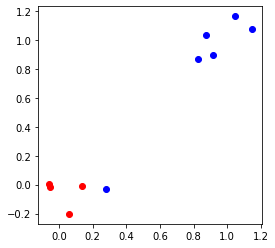

In [63]:
plot_cluster(data, final_model.clusters[0], final_model.clusters[1])

In [174]:
import importlib
import active_coresets
importlib.reload(active_coresets.maxcut_qaoa)
importlib.reload(active_coresets.quantum_algorithms)
importlib.reload(active_coresets.classical_algorithms)
importlib.reload(active_coresets.coreset_algorithms)
from active_coresets.quantum_algorithms import ClassicalExponentialSampler, VQT, QAOA

In [175]:
from active_coresets.coreset_algorithms import bayesian_inference
from active_coresets.classical_algorithms import RandomSampler, GIGACoreset
from active_coresets.quantum_algorithms import ClassicalExponentialSampler, VQT, QAOA
from active_coresets.data_structures import Coreset, Model

from typing import List, Tuple

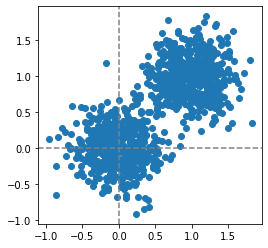

In [192]:
num_data = 1000
data, c1, c2 = gen_gaussian_data(num_data, stddev=0.3)
shuffle(data)
plot_data(data)

In [193]:
class ClusteringModel(Model):
    def __init__(self, clusters: Tuple[List[np.ndarray], List[np.ndarray]]):
        self.clusters = clusters
        self.cluster0_center = np.average(clusters[0], axis=0) if len(clusters[0]) > 0 else [0.0, 0.0]
        self.cluster1_center = np.average(clusters[1], axis=0) if len(clusters[1]) > 0 else [0.0, 0.0]
    
    def evaluate_on_coreset(self, coreset: Coreset) -> float:
        total_dist = 0.0
        for data, weight in coreset.coreset:
            if any((data == x).all() for x in self.clusters[0]):
                total_dist += weight * np.linalg.norm(data - self.cluster0_center)
            else:
                total_dist += weight * np.linalg.norm(data - self.cluster1_center)
        return -total_dist
    
    def evaluate_on_point(self, data: np.ndarray) -> float:
        if any((data == x).all() for x in self.clusters[0]):
            return np.linalg.norm(data - self.cluster0_center)
        else:
            return np.linalg.norm(data - self.cluster1_center)
        

In [194]:
def cluster_loglikelihood(data: np.ndarray, models: List[ClusteringModel]) -> np.ndarray:
    #TODO: maybe optimize this better
    ll_vecs = np.zeros((data.shape[0], len(models)))
    for i in range(data.shape[0]):
        for j in range(len(models)):
            ll_vecs[i][j] = models[j].evaluate_on_point(data[i])
    return ll_vecs


In [206]:
A = GIGACoreset(list(data), cluster_loglikelihood)
B = QAOA(1)

final_model = bayesian_inference(list(data), cluster_from_bitstring, num_data, 5, A, B)


[(0, 1, 80286.67512230354)]
[(2075.625655309556, array([0.68735203, 0.78249344])), (209.99957000604434, array([0.57477667, 0.928282  ]))]
Current iteration: 0, Num function calls: 3, best so far: -35996.0918592
Current iteration: 1, Num function calls: 5, best so far: -67119.3349835
Current iteration: 2, Num function calls: 6, best so far: -67119.3349835
Current iteration: 3, Num function calls: 8, best so far: -67119.3349835
Current iteration: 4, Num function calls: 10, best so far: -67119.3349835
Current iteration: 5, Num function calls: 12, best so far: -67711.4170591
Current iteration: 6, Num function calls: 14, best so far: -79500.1194406
Current iteration: 7, Num function calls: 16, best so far: -79500.1194406
Current iteration: 8, Num function calls: 17, best so far: -79500.1194406
Current iteration: 9, Num function calls: 21, best so far: -79500.1194406
Current iteration: 10, Num function calls: 25, best so far: -79500.1194406
Current iteration: 11, Num function calls: 27, best

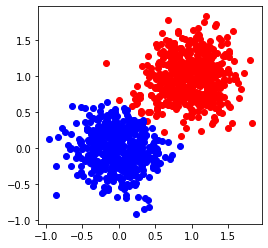

In [207]:
plot_cluster(data, final_model.clusters[0], final_model.clusters[1])

In [210]:
A = RandomSampler()
B = QAOA(1)

final_model = bayesian_inference(list(data), cluster_from_bitstring, num_data, 5, A, B)

[(0, 1, 1.1125154735388498)]
[(1, array([0.53637322, 0.11432385])), (1, array([-0.55782465, -0.08672762]))]
Current iteration: 0, Num function calls: 3, best so far: -0.6131755
Current iteration: 1, Num function calls: 5, best so far: -0.7270230
Current iteration: 2, Num function calls: 6, best so far: -0.7270230
Current iteration: 3, Num function calls: 8, best so far: -0.8479631
Current iteration: 4, Num function calls: 12, best so far: -0.8479631
Current iteration: 5, Num function calls: 13, best so far: -0.8479631
Current iteration: 6, Num function calls: 15, best so far: -0.8479631
Current iteration: 7, Num function calls: 19, best so far: -0.9581068
Current iteration: 8, Num function calls: 21, best so far: -0.9581068
Current iteration: 9, Num function calls: 25, best so far: -1.1065854
Current iteration: 10, Num function calls: 27, best so far: -1.1065854
Current iteration: 11, Num function calls: 31, best so far: -1.1065854
Current iteration: 12, Num function calls: 33, best so

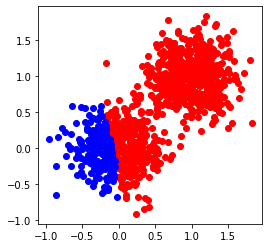

In [211]:
plot_cluster(data, final_model.clusters[0], final_model.clusters[1])